In [1]:
import sys
sys.path.insert(0, '/global/cfs/projectdirs/desi/users/akim/gcr-catalogs')
import GCRCatalogs
sys.path.insert(0, '/global/cfs/projectdirs/desi/users/akim/lsstdesc-diffsky')
from lsstdesc_diffsky.constants import MAH_PNAMES, MS_U_PNAMES, Q_U_PNAMES

In [2]:
import numpy
import jax
from matplotlib import pyplot as plt
from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap

mred = u'#d62728' 
mgreen = u'#2ca02c'
mblue = u'#1f77b4' 

In [3]:
from sn_diffstar.load_bpl import *
from sn_diffstar.mspop import *
from sn_diffstar.utils import *

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
z_true_max=0.1

In [5]:
cname='skysim_v3.1.0'

In [6]:
catalog = GCRCatalogs.load_catalog(cname)

In [7]:
pv_params=['redshift_true', 'redshift','position_x', 'position_y', 'position_z', 
           'velocity_x', 'velocity_y', 'velocity_z','stellar_mass']

In [8]:
params = numpy.concatenate([MAH_PNAMES, MS_U_PNAMES, Q_U_PNAMES,pv_params])

['diffmah_logmp_fit' 'diffmah_mah_logtc' 'diffmah_early_index'
 'diffmah_late_index' 'diffstar_u_lgmcrit' 'diffstar_u_lgy_at_mcrit'
 'diffstar_u_indx_lo' 'diffstar_u_indx_hi' 'diffstar_u_tau_dep'
 'diffstar_u_qt' 'diffstar_u_qs' 'diffstar_u_q_drop' 'diffstar_u_q_rejuv'
 'redshift_true' 'redshift' 'position_x' 'position_y' 'position_z'
 'velocity_x' 'velocity_y' 'velocity_z' 'stellar_mass']


## The expected MAH parameters from previous code are
['mah_fit_logmp', 'mah_fit_logtc', 'mah_fit_early_index', 'mah_fit_late_index']
['sfh_fit_u_lgmcrit',
 'sfh_fit_u_lgy_at_mcrit',
 'sfh_fit_u_indx_lo',
 'sfh_fit_u_indx_hi',
 'sfh_fit_u_tau_dep']

In [29]:
snrs=[]
smasss=[]
d=0
for all_params in catalog.get_quantities(params, return_iterator=True):
    w=numpy.where(all_params['redshift_true'] <= z_true_max)[0]
    if len(w) > 0:
        if d==10:
            wfe
        t0s = catalog.cosmology.age(all_params['redshift_true'][w])
        mah_params = numpy.vstack((all_params['diffmah_logmp_fit'][w],
                                  all_params['diffmah_mah_logtc'][w],
                                  all_params['diffmah_early_index'][w],
                                  all_params['diffmah_late_index'][w])).T
        
        ms_u_params = numpy.vstack((all_params['diffstar_u_lgmcrit'][w],
                                  all_params['diffstar_u_lgy_at_mcrit'][w],
                                  all_params['diffstar_u_indx_lo'][w],
                                  all_params['diffstar_u_indx_hi'][w],
                                  all_params['diffstar_u_tau_dep'][w])).T
        q_u_params = numpy.vstack((all_params['diffstar_u_qt'][w],
                                  all_params['diffstar_u_qs'][w],
                                  all_params['diffstar_u_q_drop'][w],
                                  all_params['diffstar_u_q_rejuv'][w])).T
        
        
        ans=SNR_gal(t0s, A, beta, tp, mah_params, ms_u_params, q_u_params)
        keep = ~numpy.isnan(ans)
        ans=ans[keep]
        snrs=numpy.append(snrs,ans)
        smasss=numpy.append(smasss,all_params['stellar_mass'][w[keep]])

        d=d+1

NameError: name 'wfe' is not defined

In [23]:
print(tp,t0s)

0.04 [12.83062276 12.83026053 12.83082783 12.83047341 12.8303704  12.83025955
 12.83031943 12.8307572  12.84102978 12.84028886 13.03981691 13.03935138
 13.04002695 13.0396159  12.87715698 12.84160244 12.84327863 12.84196933
 12.84297217 12.88947223 12.88995944 12.82297835 12.82447457 12.84534728
 12.87774309 12.8528491  12.78421554 12.84727595 13.04020749 13.04039357
 12.89121139 12.79611925 12.8867973  12.79447464 12.8772754  12.82849938
 12.82836786 12.82888572 12.82881867 12.82919136 12.82895683 12.84065652
 12.78766184 12.78735024 12.7878197  12.78739978 12.7876514  12.78783089
 12.88766164 12.82549773 12.82564294 12.82590844 12.8254228  12.76935805
 12.76935805 12.76935805 12.87574957 13.04060257 13.00828125 13.00869098
 12.82954626 13.00357624 12.82785478 12.83127403 12.82858863 12.82686819
 12.8283981  12.82807867 12.82828396 12.82907036 12.82670092 12.82819672
 12.82637949 12.82794737 12.82921699 12.82774541 12.8286241  12.82849941
 12.82663543 12.82682587 12.82805037 12.831265

In [24]:
numpy.isnan(snrs.sum())

False

In [25]:
bins=numpy.linspace(6.5,11.75,22)
print(bins)

[ 6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75  9.    9.25
  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75]


In [30]:
digitized = numpy.digitize(numpy.log10(smasss), bins)
bin_means = [numpy.log10(snrs)[digitized == i].mean() for i in range(1, len(bins))]
bin_stds = [numpy.log10(snrs)[digitized == i].std() for i in range(1, len(bins))]
print(bin_means)           

[-3.424473627738363, -4.141917665475651, -4.565531558397845, -4.7841339817572095, -4.465698122879493, -4.329246722958002, -4.237019959856288, -3.94609145671043, -3.795442012542859, -3.72053471178159, -3.5601009499455, -3.480371107290984, -3.164846900169778, -3.101272957544665, -3.1589961507149003, -3.111670169920356, -3.005970080049103, -2.860721541063107, -2.956090637292136, -3.023081243659944, -3.34687558681801]


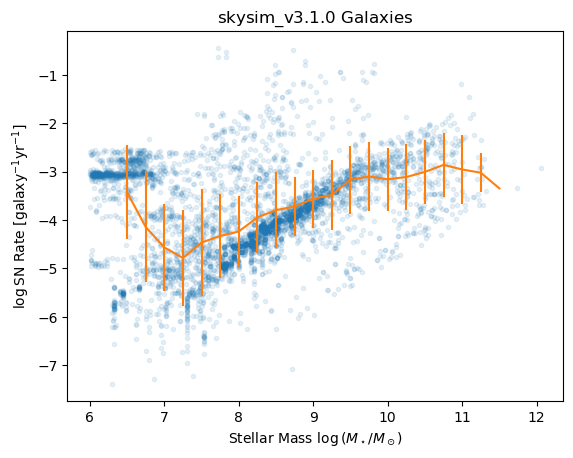

In [31]:
fig, ax = plt.subplots(1, 1)
ax.plot(numpy.log10(smasss),numpy.log10(snrs),'.',alpha=0.1)
ax.errorbar(bins[:-1],bin_means,bin_stds)
xlabel = ax.set_title(r'${\rm skysim\_v3.1.0\ Galaxies}$')
xlabel = ax.set_xlabel(r'${\rm Stellar\ Mass\ } \log{(M_\star/M_\odot)}$')
ylabel = ax.set_ylabel(r'$ \log{\rm SN\ Rate\ }[{\rm galaxy}^{-1}{\rm yr}^{-1}]$')

In [13]:
snrs.min()

nan

## Pick an arbitray slice and associated cosmic time to consider

In [ ]:
sslice = 110
t0s=data[1][sslice]
print(t0s)

## Get SN Rates sim, diffstar fit (in-situ only) and Stellar Mass (sim) (diffstar fit does not have mass loss)

In [19]:
SNR_sim=[]
SNR_fit=[]
logSM_sim=[]
logSM_fit=[]

ilim= t0s - tp
# this is buggy if tp is larger than a slice...
x = data[1][:sslice]
x = numpy.append(x,ilim)
x = numpy.insert(x,0,0)

if not numpy.all(numpy.diff(x) > 0):
    print('Bad things happening')
    exit()

ind=0

for row in data[0]:
#     t0s=numpy.random.uniform(5,13)
    if (ind % 100) == 0:      

        flim= numpy.interp(ilim,data[1],row['sfrh_sim'])
        y = row['sfrh_sim'][:sslice]
        y = numpy.append(y,flim)
        y = numpy.insert(y,0,0)
        integral = 1e9 * A * numpy.trapz(y*numpy.power(t0s-x,beta),x)                       
        SNR_sim.append(integral)
        
        mah_params_one= numpy.array(list(row[data[2][0]]))        
        SNR_fit.append(SNR(t0s, A, beta, tp, mah_params_one))
        
        logSM_fit.append(logSM(t0s, mah_params_one))
        logSM_sim.append(row['logsmh_sim'][sslice])
    ind = ind+1

SNR_sim=numpy.array(SNR_sim)
SNR_fit=numpy.array(SNR_fit)
logSM_sim = numpy.array(logSM_sim)
logSM_fit = numpy.array(logSM_fit)

## Stellar mass versus SNR

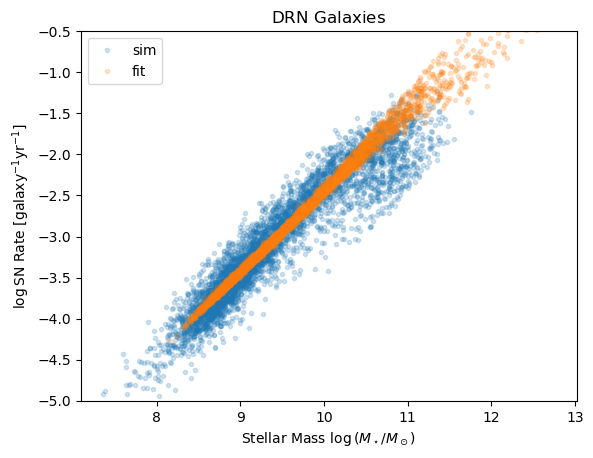

In [20]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(logSM_sim, numpy.log10(SNR_sim),'.',label='sim',alpha=0.2)
__=ax.plot(logSM_fit, numpy.log10(SNR_fit),'.',label='fit',alpha=0.2)
ax.set_ylim((-5,-0.5))
xlabel = ax.set_title(r'${\rm DRN\ Galaxies}$')
xlabel = ax.set_xlabel(r'${\rm Stellar\ Mass\ } \log{(M_\star/M_\odot)}$')
ylabel = ax.set_ylabel(r'$ \log{\rm SN\ Rate\ }[{\rm galaxy}^{-1}{\rm yr}^{-1}]$')
ax.legend()

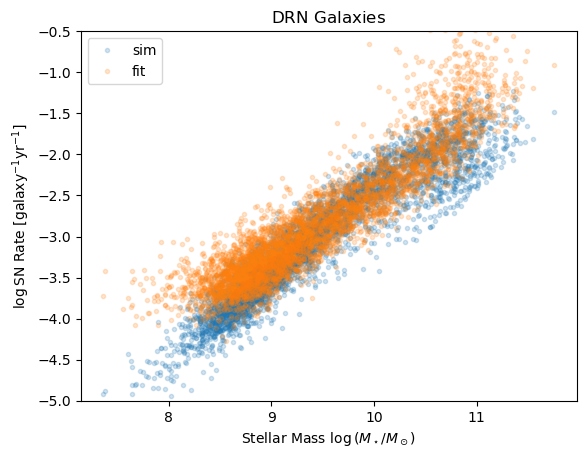

In [21]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(logSM_sim, numpy.log10(SNR_sim),'.',label='sim',alpha=0.2)
__=ax.plot(logSM_sim, numpy.log10(SNR_fit),'.',label='fit',alpha=0.2)
ax.set_ylim((-5,-0.5))
xlabel = ax.set_title(r'${\rm DRN\ Galaxies}$')
xlabel = ax.set_xlabel(r'${\rm Stellar\ Mass\ } \log{(M_\star/M_\odot)}$')
ylabel = ax.set_ylabel(r'$ \log{\rm SN\ Rate\ }[{\rm galaxy}^{-1}{\rm yr}^{-1}]$')
ax.legend()

## Check sim and fit SN Rate

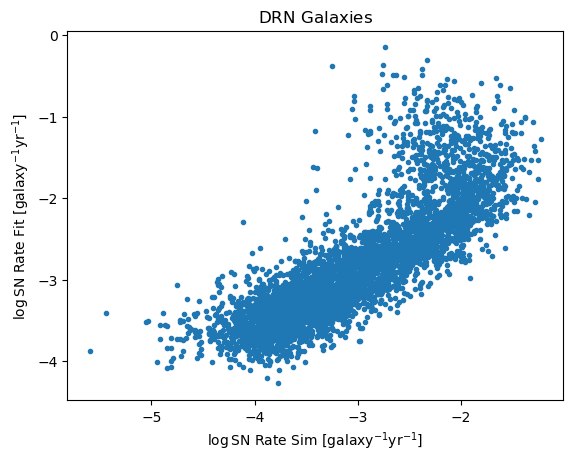

In [17]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(numpy.log10(SNR_sim),numpy.log10(SNR_fit),'.')

tlabel = ax.set_title(r'${\rm DRN\ Galaxies}$')
xlabel = ax.set_xlabel(r'$ \log{\rm SN\ Rate\ Sim\ }[{\rm galaxy}^{-1}{\rm yr}^{-1}]$')
ylabel = ax.set_ylabel(r'$ \log{\rm SN\ Rate\ Fit\ }[{\rm galaxy}^{-1}{\rm yr}^{-1}]$')

## Check sim and fit Stellar Mass
It is known that they will be different

In [7]:
logSM_sim=[]
logSM_fit=[]
tarr = jnp.linspace(0.1, t0s, 200)
count=0
for row in data[0]:
    if (count % 1000) == 0:
        mah_params_one= numpy.array(list(row[data[2][0]]))
        ms_u_params_pop, ms_sfh_pop, ms_logsmh_pop = mc_galhalo_ms_lgmpop(ran_key, mah_params_one[None,:], tarr)
        logSM_fit.append(ms_logsmh_pop[0,-1])
        logSM_sim.append(row['logsmh_sim'][sslice])
    count = count+1

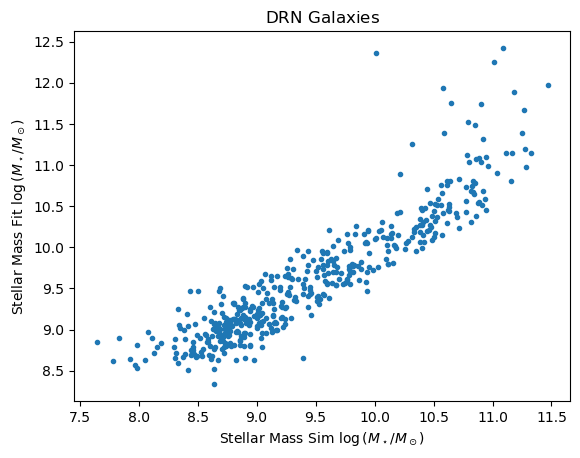

In [8]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(logSM_sim, logSM_fit, '.')

tlabel = ax.set_title(r'${\rm DRN\ Galaxies}$')
xlabel = ax.set_xlabel(r'${\rm Stellar\ Mass\ Sim\ } \log{(M_\star/M_\odot)}$')
xlabel = ax.set_ylabel(r'${\rm Stellar\ Mass\ Fit\ } \log{(M_\star/M_\odot)}$')

In [ ]:
logSM_fit=data[0]['logsmh_sim'].value[:,sslice].shape

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(logSM_fit, ms_logsmh_pop[:,-1],'.',label='fit',alpha=0.2)

xlabel = ax.set_title(r'${\rm DRN\ Galaxies}$')
xlabel = ax.set_xlabel(r'${\rm Stellar\ Mass\ } \log{(M_\star/M_\odot)}$')
ylabel = ax.set_ylabel(r'$ \log{\rm SN\ Rate\ }[{\rm galaxy}^{-1}{\rm yr}^{-1}]$')


In [ ]:
logSM_fit=[]
SNR_fit=[]
ind=0
for row in data[0]:
#     t0s=numpy.random.uniform(5,13)
    if (ind % 100) == 0:
        mah_params=numpy.fromiter(row[data[2][0]].values(),float,-1)
        logSM_fit.append(logSM(t0s,mah_params))
        SNR_fit.append(SNR(t0s, A, beta, tp, mah_params))
    ind = ind+1

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(logSM_fit, numpy.log10(SNR_fit),'.',label='fit',alpha=0.2)

__=ax.plot(logSM_sim, numpy.log10(SNR_sim),'.',label='sim',alpha=0.2)

xlabel = ax.set_title(r'${\rm DRN\ Galaxies}$')
xlabel = ax.set_xlabel(r'${\rm Stellar\ Mass\ } \log{(M_\star/M_\odot)}$')
ylabel = ax.set_ylabel(r'$ \log{\rm SN\ Rate\ }[{\rm galaxy}^{-1}{\rm yr}^{-1}]$')


# t0s=numpy.random.uniform(5, 13., Ngal)
# __=ax.plot(logSM_mah(t0s, mah_params_pop), jnp.log10(SNR_mah(t0s, A, beta, tp, mah_params_pop)),'.',label='MS')
ax.legend()


In [ ]:
data[0]

In [ ]:
data[1][sslice]

In [ ]:
dum=(data[1][:sslice])

In [ ]:
print(numpy.all(numpy.diff(x) > 0))

## DIFFSTAR SFH
Use an example galaxy that has been parameterized by DIFFSTAR

In [ ]:
from diffmah.monte_carlo_halo_population import mc_halo_population

Ngal=500
T0 = 13.8
tarr = numpy.linspace(0.1, T0, 200)

logmhpop = numpy.zeros(Ngal) + 12.0
halopop = mc_halo_population(tarr, T0, logmhpop)

# Collect mah_params into array of shape (n_halos, 4)
mah_params_pop = numpy.array((halopop.log_mah[:, -1], halopop.lgtc, halopop.early_index, halopop.late_index)).T

In [ ]:
halopop.log_mah.shape

## Supernova Rate

In [ ]:
from sn_diffstar.utils import *

In [ ]:
t0=5
betas = numpy.linspace(-1.25,-1,20)
tps= numpy.linspace(0.02,0.06,20)

In [ ]:
t0s=numpy.random.uniform(5, 13., Ngal)
fig, ax = plt.subplots(1, 1)
__=ax.plot(logSM_gal(t0s, mah_params_pop), jnp.log10(SNR_gal(t0s, A, beta, tp, mah_params_pop)),'.')
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
xlabel = ax.set_xlabel(r'${\rm Stellar\ Mass\ } \log{(M_\star/M_\odot)}$')
ylabel = ax.set_ylabel(r'$ \log{\rm SN\ Rate\ }[{\rm galaxy}^{-1}{\rm yr}^{-1}]$')

In [ ]:
t0s=numpy.random.uniform(5, 13., Ngal)
fig, ax = plt.subplots(1, 1)
__=ax.plot(t0s, SNR_gal(t0s, A, beta, tp, mah_params_pop),'.')
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(betas, SNR_beta(t0, A, betas, tp, mah_params_pop[0,:]))
xlabel = ax.set_xlabel(r'$\beta$')
xlabel = ax.set_title(r'${{\rm One\ Diffstar\ Main\ Sequence\ Galaxy}}$ at Lookback {} Gyr'.format(t0))
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(tps, SNR_tp(t0, A, beta, tps, mah_params_pop[0,:]))
xlabel = ax.set_xlabel(r'$t_p (Gyr)$')
xlabel = ax.set_title(r'${{\rm One\ Diffstar\ Main\ Sequence\ Galaxy}}$ at Lookback {} Gyr'.format(t0))
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

In [ ]:
fig, ax = plt.subplots(1, 1)
im=ax.imshow(SNR_beta_tp(t0, A, betas, tps, mah_params_pop[0,:]),extent=[betas[0], betas[-1], tps[0], tps[-1]])
ax.set_aspect(7)
fig.colorbar(im, ax=ax,label='SN Rate')
xlabel = ax.set_xlabel(r'$\beta$')
xlabel = ax.set_ylabel(r'$t_p (Gyr)$')
xlabel = ax.set_title(r'${{\rm One\ Diffstar\ Main\ Sequence\ Galaxy}}$ at Lookback {} Gyr'.format(t0))

### As a function of DDT parameters

In [ ]:
t0s=jnp.linspace(0.1, 13.8, 10)
fig, ax = plt.subplots(1, 1)
__=ax.plot(t0s, SNR_t0(t0s, A, beta, tp, mah_params_pop[0,:]))
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(SNR_mah(5, A, beta, tp, mah_params_pop))
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

In [ ]:
t0s=jnp.linspace(0.1, 13.5, 20)
fig, ax = plt.subplots(1, 1)
__=ax.plot(t0s, SNR_t0_mah(t0s, A, beta, tp, mah_params_pop))
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

## Delay time distribution (DTD) Eq. 6 of https://academic.oup.com/mnras/article/506/3/3330/6318383?login=false

In [ ]:
@jjit
## tau    (Gyr)
## tp      (Gyr)
## A   (1e-13 M^{-1}_{sun} yr^{-1}
##
##  Nominal values A=2.11; beta=-1.13; tp=0.04

def DTD(tau, A, beta, tp):
    return jax.lax.cond(tau < tp, lambda a: 0., lambda a : a[0]*jnp.power(a[1],a[2]), [A, tau, beta])

In [ ]:
DTD_vmap = jjit(vmap(DTD, in_axes=(0, None, None, None)))

In [ ]:
tau = jnp.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1)
__=ax.plot(tau, DTD_vmap(tau, A, beta, tp))